In [253]:
# For second Order SFs ... it just might work
#%% Setup Packages
import xarray as xr
from xarray import open_mfdataset
import dask
import dask.array as da
import netCDF4 as netcdf
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import animation, rcParams, cycler
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from scipy.signal import argrelextrema
import dateutil

import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
from metpy.units import units
import itertools
import scipy.spatial
import scipy.special
import sklearn.metrics
from fractions import Fraction
import hankel

import sys
import os
from importlib import reload

sys.path.insert(1,r"/export/home1/jbenjami/Research_Thompson/Python/personal/")
print(sys.path)
import personal

import personal.math as pm
import personal.data_structures
import personal.date_operations
import personal.SMODE
import personal.calculations
import personal.geometry
import personal.system
import personal.plots
import personal.IO
import personal.constants
import personal.geospatial

import hankel, pyhank, pyfftlog

a1d = np.atleast_1d

seasons          = {'DJF':[12, 1, 2],'JFM':[ 1, 2, 3],'FMA':[ 2, 3, 4],
                    'MAM':[ 3, 4, 5],'AMJ':[ 4, 5, 6],'MJJ':[ 5, 6, 7],
                    'JJA':[ 6, 7, 8],'JAS':[ 7, 8, 9],'ASO':[ 8, 9,10],
                    'SON':[ 9,10,11],'OND':[10,11,12],'NDJ':[11,12, 1]}

cmap = LinearSegmentedColormap.from_list("mycmap", [[0,0,1],[0,1,.5],[1,0,0],'yellow',[0,0,1]],N=13)
colors = cmap(np.linspace(0, 1, 13)[0:12])

import gc; gc.collect()

file_path        = os.path.abspath(os.path.dirname(''))
data_relpath     = "../Data/HF_Radar/2km/processed/smode_region/"
output_savepath  = "../Data/HF_Radar/2km/processed/smode_region/miscellaneous/"
data_source      = os.path.normpath(os.path.join(file_path, data_relpath))


# m = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'LLC4320_KE_smoothed_rolling_seas_sf.pkl')['structure_fcn']['AMJ']


# data_relpath     = "../Data/HF_Radar/2km/processed/smode_region/"
# output_savepath  = "../Data/HF_Radar/2km/processed/smode_region/miscellaneous"
# data_source      = os.path.normpath(os.path.join(file_path, data_relpath))
# m = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' +              'smode_speed_sf_monthly.pkl')['structure_fcn']['AMJ'] 


m_seas = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' +              'smode_speed_sf_monthly.pkl')['structure_fcn']
m = m_seas['AMJ'].dropna()

['/export/home1/jbenjami/Research_Thompson/Python', '/export/home1/jbenjami/Research_Thompson/Python/personal/', '/export/home1/jbenjami/Research_Thompson/Python/personal/', '/export/home1/jbenjami/anaconda3/lib/python37.zip', '/export/home1/jbenjami/anaconda3/lib/python3.7', '/export/home1/jbenjami/anaconda3/lib/python3.7/lib-dynload', '', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/export/home1/jbenjami/.ipython']


In [2]:
# m = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'HFRADAR_2KM_KE_sf_test.pkl')['structure_fcn']['all']
m = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'HFRADAR_2KM_KE_baseline_all_sf.pkl')['structure_fcn']['all']

m = m.dropna()
SF = {'r':np.array(m.index), 'S':m.values}
SF['r_lims'] = personal.math.range_bounds(SF['r'])


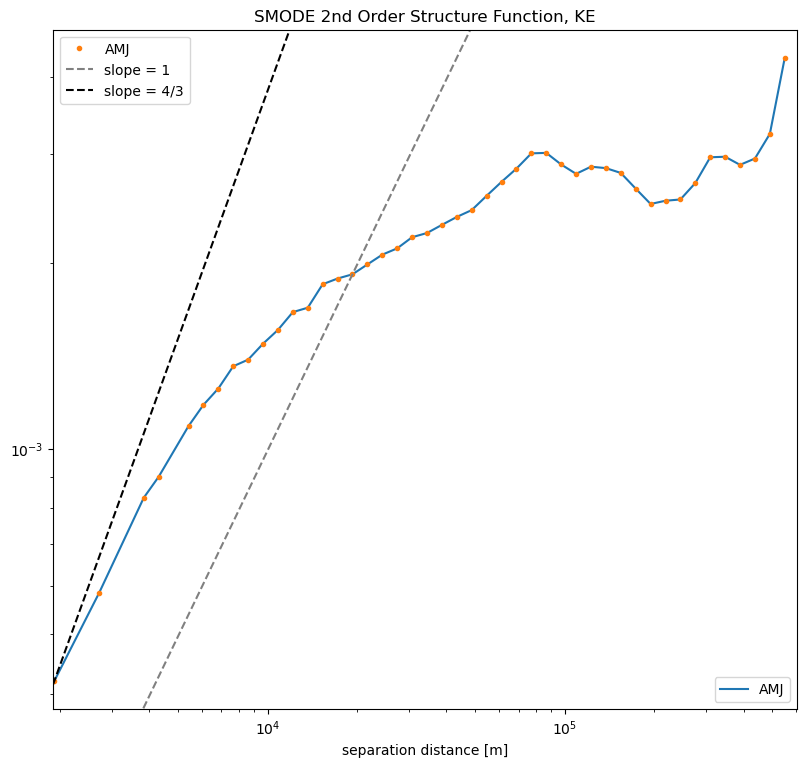

In [3]:
_=gc.collect()
reload(personal.plots)
fig = personal.plots.default_figure()
m = m.dropna()
_ax = m.plot(logx=True,logy=True,ylim=[np.nanmin(m.values[:]),np.nanmax(m.values[:])]*np.array([.9,1/.9]),label='AMJ')
_ax = m.plot(logx=True,logy=True,ylim=[np.nanmin(m.values[:]),np.nanmax(m.values[:])]*np.array([.9,1/.9]),label='AMJ',style='.')

_ax.set_xlim(np.array([m.index[0]*0.9,m.index[-1]])*1.1)
_ax.set_xlabel('separation distance [m]')
_ax.set_title('SMODE 2nd Order Structure Function, KE')

slope = Fraction(  1); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m.index[15] ,m.values[15]]  ,color='gray' ,linestyle='--',label='slope = ' + str(slope))
slope = Fraction(4,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[m.index[ 0] ,m.values[ 0]]  ,color='k'    ,linestyle='--',label='slope = ' + str(slope))

leg  = _ax.get_legend_handles_labels()
leg1 = _ax.legend(leg[0][0:1], leg[1][ 0:1], loc='lower right',ncol=4)
_    = _ax.legend(leg[0][1: ], leg[1][1:  ], loc='upper left' ,ncol=1)
_    = _ax.add_artist(leg1)

In [185]:
S_in = SF['S'].copy()
S_in   = personal.math.monotonicize(S_in); 

In [646]:
np.nanvar(np.log10(S_in))

0.04498236862199323

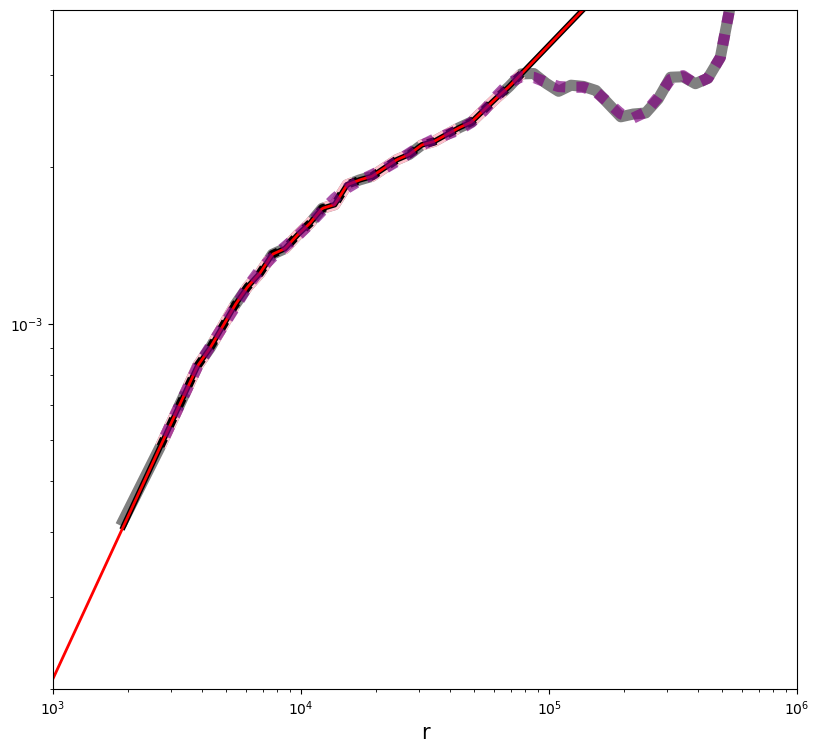

In [180]:
r_in   = SF['r'].copy(); S_in = SF['S'].copy()
start  = 1
end    = -19;
S_in   = S_in[start:]; r_in = r_in[start:]

# r_poly, S_poly = r_in.copy(), np.polyfit(r_in, S_in,10) # worse (esp at low vals)
# S_polyvals = np.polyval(S_poly,r_poly)

# r_poly, S_poly = r_in.copy(), np.polyfit(r_in, np.log10(S_in),10) # terrible
# S_polyvals = 10**np.polyval(S_poly,r_poly)

# r_poly, S_poly = r_in.copy(), np.polyfit(np.log10(r_in), S_in,100) # better, but worse at low vals
# S_polyvals = np.polyval(S_poly,np.log10(r_poly))

r_poly, S_poly = r_in.copy(), np.polyfit(np.log10(r_in), np.log10(S_in),100) # better
S_polyvals = 10**np.polyval(S_poly,np.log10(r_poly))

# # S_in[end:] = np.maximum(S_in[end-1], np.nanmean(S_in[end:]))
# S_in[end:] = np.maximum(S_in[end-1], np.nanmean(S_in[end:]))
# cut_end=True
if cut_end:
    r_in = r_in[:end+2]
    S_in = S_in[:end+2]

# E_tot = S_in[-1]/2
E_tot = np.max(S_in)/2  
fill = "extrapolate"                                                    
f_filter = lambda r: (a1d(r) >= np.min(r_in)) 
# f_filter = lambda r: (a1d(r) >= np.min(r_in)) * (a1d(r) <= np.max(r_in))
f_filter = lambda r: 1

monotonicize=False
if monotonicize: # make vector monotonic to reduce ringing anywhere
    S_in   = personal.math.monotonicize(S_in); 
    _, idx = np.unique(S_in,return_index=True);
    idx    = np.sort(idx)
    r_max  = r_in[-1]
    r_in   = r_in[idx]
    r_in   = np.append(r_in,r_max)
    S_in   = S_in[idx] 
    S_in   = np.append(S_in,S_in[-1])
    
def smoother(r,S):
    S   = np.append(S,S[-1])
    r   = np.append(r,r[-1]*2)
    
#     weights      = 1/np.log10(r);
    weights      = np.log10(r)/np.log10(r);
    weights      = weights ** +6;
    weights[-2:] = np.max(weights)*10
    weights      = weights/np.sum(weights)
    s            =  (1e-10)/(len(S) * np.nanvar(np.log10(S)))
    print(s)
    S            = scipy.interpolate.UnivariateSpline(np.log10(r),S, k=3, s=s, w=weights)(np.log10(r))
    return r,S


    
    
smooth=False
if smooth:
#     S_in   = 10**personal.math.rolling_mean(np.log10(S_in),window=3,min_count=1)
    r_in,S_in = smoother(r_in,S_in)

interp_f = scipy.interpolate.interp1d(np.log10(r_in), np.log10(S_in), fill_value = fill, bounds_error = False)
def interp_SF(r): return 10**interp_f(np.log10(r)) 

r   = np.logspace(3,6,400) 


fig = personal.plots.default_figure()
_ax = plt.axes()
_ax.plot(SF['r'], SF['S']                  , linewidth=8, color='grey')

_ax.plot(r_in   , S_in                     , linewidth=8, color='pink',linestyle='--')
_ax.plot(r_in   , interp_SF(r_in)          , linewidth=6, color='k'   ,linestyle='dotted')
_ax.plot(SF['r'], interp_SF(SF['r'])       , linewidth=4, color='k')
_ax.plot(r      , interp_SF(r)*f_filter(r) , linewidth=2, color='r')

_ax.plot(r_poly   , S_polyvals                     , linewidth=8, color='purple', alpha = .666, linestyle=(1,(1,1)))


_ax.set_xscale('log'); _ax.set_yscale('log'); _ax.set_xlabel("r", fontsize=15)
_ax.set_ylim([2e-4, 4e-3]);
_ax.set_xlim([r[0], r[-1]]);

plt.show()

In [20]:
# --- FUNCTIONS
engines =  ['hankel','pyhank','pyfftlog']
equations = [4, 15]

setup = {}
for engine in engines:
    setup[engine] = {}
    for var in ['f', 'r_pow', 'k_pow', 'q']:
        setup[engine][var] = {}
setup['mu'] = {}
#----------------------------------------------------
i = 15; setup['mu'][i] = 1;  window = 1

r_pow = 1; setup['hankel'  ]['r_pow'][i] = r_pow; setup['hankel'  ]['k_pow'][i] = 2
r_pow = 1; setup['pyhank'  ]['r_pow'][i] = r_pow; setup['pyhank'  ]['k_pow'][i] = 2
r_pow = 2; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = r_pow-1 ; setup['pyfftlog']['q'][i] = 2-r_pow; # r_pow can vary 0-2 trivially

for engine in engines:
    setup[engine]['f'    ][i] =  lambda r: personal.math.rolling_mean(1./2 * (E_tot - 1./2 *interp_SF(a1d(r))) * a1d(r)**setup[engine]['r_pow'][i], axis=0,window=window,min_count=1) *(a1d(r)  >= np.min(r_in)) #* (a1d(r) <= np.max(r_in)) #* (a1d(r)  >= np.min(r_in)) * (a1d(r)  <= np.max(r_in))  # * (a1d(r)  >= np.min(r_in))

# ---------------------------------------------------------
i = 4; setup['mu'][i] = 0;  window = 1

r_pow = 0; setup['hankel'  ]['r_pow'][i] = r_pow; setup['hankel'  ]['k_pow'][i] = 1
r_pow = 0; setup['pyhank'  ]['r_pow'][i] = r_pow; setup['pyhank'  ]['k_pow'][i] = 1
r_pow = 1; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = r_pow-1 ; setup['pyfftlog']['q'][i] = 1-r_pow; # r_pow can vary 0-1 trivially


for engine in engines:
    ff    = lambda r:  personal.math.rolling_mean( (2*E_tot - interp_SF(a1d(r))) / 2., axis=0,window=window,min_count=1) * f_filter(r) #
    deriv = np.vectorize(lambda fcn,rv: scipy.misc.derivative(fcn,rv,dx=rv/4))
    R_ii  = lambda r: ff(r) + deriv(lambda r: ff(r) * r, r)
    setup[engine]['f'    ][i] = lambda r: personal.math.rolling_mean(R_ii(a1d(r)) * a1d(r)**setup[engine]['r_pow'][i], axis=0,window=window,min_count=1)  
    
coords = {}
logmin,logmax = np.log10(np.min(r_in)), np.log10(np.max(r_in));
# log-spaced array of k
# coords['hankel'  ] = np.logspace(-logmax, -logmin, int(1e2)) 
coords['hankel'  ] = np.logspace(-logmax, -(logmin-1), int(1e2)) 
# lin-spaced array of r, u gotta up the resolution a ton because it works in linear space, can't transform bc of J_mu(Kr) containing K and r
coords['pyhank'  ] = np.linspace(10.**2,10.**6,int(1e3))     
# lin-spaced array of log r 
n = 4096
coords['pyfftlog'] = np.linspace(logmin, logmax,n)            
# coords['pyfftlog'] = np.linspace(logmin, logmax-1,n) 

In [596]:
def full_process(
                m,
                i                        = [4,15],
                start                    = 0,
                endd                     = None, # we defaulted to -12 <--> -17 or something but you'll have to play around with it
                endval                   = 'last', # 'last' or 'mean' or 'max'
                cut_end                  = True,
                repeat_end               = True,
                fix_negs_int             = False,
                fix_negs_ext             = False,
                monotonicize             = False,
                smooth                   = False,
                smooth_window            = 1,
                smooth_min_count         = 1,
                smoother                 = smoother,
                r                        = None,
                n                        = 400,  # this is the number of points in our ourput r, 
                E_tot                    = None,
                fill                     = 'extrapolate', # fill outside our data
                f_filter                 = lambda r,r_in: (a1d(r) >= np.min(r_in)), # cut values based on this filter
                # f_filter = lambda r,r_in: (a1d(r) >= np.min(r_in)) * (a1d(r) <= np.max(r_in)),
                rolling_window           = 1,
                engines                  =  ['hankel','pyhank','pyfftlog'],
                equations                = [4, 15],
                r_fcn                    = lambda r_in:  np.logspace( np.floor(np.log10(r_in[0])), np.ceil(np.log10(r_in[-1])), 400),
                setup_structure_func     = True,
                r_scale                  = 1./1000,
                S_scale                  = 1000,
                periodicize              = False,
                periodic_cut_middle      = True,
                dxscale                  = 2,
                make_data_plots          = True,
                make_eqns_plots          = True,
                data_plot_scales         = ['symlog','log'],
                engine_plot_scales       = ['log','log','log'],
                figures_inline           = True,
                data_fig_scale           = 1,
                eqns_fig_scale           = 1
                ):

    
    m = m.dropna()
    SF = {'r':np.array(m.index), 'S':m.values}
    SF['r_lims'] = personal.math.range_bounds(SF['r'])

    r_in   = SF['r'].copy(); S_in = SF['S'].copy()
    
    r_in_orig,S_in_orig = r_in.copy(), S_in.copy()

    
    if endd is None:
        endd = len(SF['S'])-1

        
    S_in = S_in[start:]; r_in = r_in[start:]

    # reduce ringing at large scales
    if endval is 'last':
        endval = S_in[endd]
    elif endval is 'mean':
        endval = np.nanmean(S_in[endd:])
    elif endval is 'max':
        endval = np.maximum(S_in[endd], np.nanmean(S_in[endd:]))
        
    S_in[endd:] = endval
    if cut_end:
        L = len(r_in)
        if endd is None:
            endd = L
        if endd < 0:
            endd = L + endd
        real_end  = endd + repeat_end
        if  real_end > L:
            to_add = real_end - L
            r_in   = np.concatenate( (r_in[:], r_in[-1] + np.arange(1,to_add+1)) ) # add 1s
            S_in   = np.concatenate( (S_in[:], np.repeat(S_in[-1],to_add)) )
        else:
            r_in = r_in[:real_end]
            S_in = S_in[:real_end]
            
#         r_in = r_in[:endd+repeat_end]
#         S_in = S_in[:endd+repeat_end]
            
        
#     S_in[endd:] = 0 # testing
        
    if monotonicize: # make vector monotonic to reduce ringing anywhere
        S_in   = personal.math.monotonicize(S_in); 
        _, idx = np.unique(S_in,return_index=True);
        idx    = np.sort(idx)
        r_max  = r_in[-1]
        r_in   = r_in[idx]
        r_in   = np.append(r_in,r_max)
        S_in   = S_in[idx] 
        S_in   = np.append(S_in,S_in[-1])
        
    if smooth:
#         S_in   = personal.math.rolling_mean(S_in,window=smooth_window,min_count=smooth_min_count)
        r_in, S_in = smoother(r_in, S_in)


    r_in = r_in * r_scale 
    S_in = S_in * S_scale
    
    # Select E_tot such that the function asymptotes to 0 as r --> infty
    if E_tot is None:
        E_tot = S_in[-1]/2    
#         E_tot = np.max(S_in)/2  
    

    if fill is None:
        fill     = "extrapolate",
        
        
    if f_filter is None:
        f_filter = lambda r,r_in: (a1d(r) >= np.min(r_in)) 

    f_temp = f_filter
    f_filter = lambda r: f_temp(r,r_in) # adjust 
    

        
    
    interp_f = scipy.interpolate.interp1d(np.log10(r_in), np.log10(S_in), fill_value = fill, bounds_error = False)
    if fix_negs_ext:
        print('Pinning SF to E_tot/2 beyond maximum given r')

    def interp_SF(r,fix_negs_ext=fix_negs_ext): 
        out = 10**interp_f(np.log10(r)) * f_filter(r)
        if fix_negs_ext:
            out[ r >= r_in[-1] ] = E_tot*2 * f_filter(r)
        return out

    
#     def interp_SF(r): return r/(r**2 + 1) # testing
#     def interp_SF(r): return  r**(0 + 1) * np.exp(-(r**2)/2.0) # testing

    if r_fcn is None:
        r = r_in
    else:
        r = r_fcn(r_in)
        # print(r)
        
    
    
    if make_data_plots:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18*data_fig_scale,9*data_fig_scale),facecolor='white') # prepare our 2x2 grid of subplots in side our figure
        axes_list = axes.flatten()   
        scales = data_plot_scales
#         scales = ['symlog','log']
        for _ax,scale in zip(axes_list,scales):
            y_reg = S_in         * f_filter(r_in)
            y_int = interp_SF(r) * f_filter(r)
            _ax.plot(r_in_orig, S_in_orig, color=[0,.75,0,.5], linewidth=4, linestyle='-'     , label='original data')
            _ax.plot(r_in     , y_reg    , color='black'     , linewidth=1, linestyle='-'     , label='processed data')
            _ax.plot(r        , y_int    , color='blue'      , linewidth=1, linestyle='dashed',label='interp fcn')
            _ax.legend(fontsize = 20*(data_fig_scale**.75))
#             _ax.legend(fontsize = 20*data_fig_scale)
            _ax.set_yscale(scale)
            _ax.set_xscale(scale)
            _ax.axhline(E_tot*2, linestyle='--',alpha=.4, color='k')
            yr0 = personal.math.range_bounds(y_reg)
            yr1 = personal.math.range_bounds(y_int)
            yr2 = personal.math.range_bounds(S_in_orig)
            np.maximum.reduce([yr[0] for yr in [yr0,yr1,yr2]])        
            _ax.set_ylim([ np.minimum.reduce([yr[0] for yr in [yr0,yr1,yr2]]) *.9, np.maximum.reduce([yr[1] for yr in [yr0,yr1,yr2]]) *1.1])
            _ax.tick_params(labelsize=np.int(20*np.sqrt(data_fig_scale)))
        if figures_inline:
            display(fig)
            plt.close(fig)
    



        
    
    # --- FUNCTIONS
    if engines is None:
        engines =  ['hankel','pyhank','pyfftlog']
    if equations is None:
        equations = [4, 15]

    setup = {}
    for engine in engines:
        setup[engine] = {}
        for var in ['f', 'r_pow', 'k_pow', 'q']:
            setup[engine][var] = {}
    setup['mu'] = {}
    
    for i in equations:
        if setup_structure_func:
            if fix_negs_int:
                E_diff = lambda r: np.maximum(E_tot - interp_SF(a1d(r))/2, 0)
                print('Pinning E_tot - SF/2 to 0 if negative everywhere, including interior')

            else:
                E_diff = lambda r: E_tot - interp_SF(a1d(r))/2
            #----------------------------------------------------
            if i == 15:
                setup['mu'][i] = 1;
                
                r_pow = 1; setup['hankel'  ]['r_pow'][i] = r_pow; setup['hankel'  ]['k_pow'][i] = 2
                r_pow = 1; setup['pyhank'  ]['r_pow'][i] = r_pow; setup['pyhank'  ]['k_pow'][i] = 2
                r_pow = 2; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = r_pow-1 ; setup['pyfftlog']['q'][i] = 2-r_pow; # r_pow can vary 0-2 trivially, q = 0 is typically best

                for engine in engines:
                    setup[engine]['f'    ][i] =  lambda r: personal.math.rolling_mean(1./2 * E_diff(r) * a1d(r)**setup[engine]['r_pow'][i], axis=0,window=rolling_window,min_count=1) * f_filter(r) #(a1d(r)  >= np.min(r_in)) #* (a1d(r) <= np.max(r_in)) #* (a1d(r)  >= np.min(r_in)) * (a1d(r)  <= np.max(r_in))  # * (a1d(r)  >= np.min(r_in))
        # ---------------------------------------------------------
            if i == 4:
                setup['mu'][i] =  0;

                r_pow = 0; setup['hankel'  ]['r_pow'][i] = r_pow; setup['hankel'  ]['k_pow'][i] = 1
                r_pow = 0; setup['pyhank'  ]['r_pow'][i] = r_pow; setup['pyhank'  ]['k_pow'][i] = 1
                r_pow = 1; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = r_pow-1 ; setup['pyfftlog']['q'][i] = 1-r_pow; # r_pow can vary 0-1 trivially, q = 0 is typically best

                for engine in engines:
                    ff    = lambda r:  E_diff(r)  * f_filter(r) #

                    deriv = np.vectorize(lambda rv: scipy.misc.derivative(lambda r: ff(r) * r, rv,dx=rv/dxscale,order=3))
                    R_ii  = lambda r: ff(r) + deriv(r)
                    setup[engine]['f'    ][i] = lambda r: personal.math.rolling_mean(R_ii(a1d(r)) * a1d(r)**setup[engine]['r_pow'][i], axis=0,window=rolling_window,min_count=1)  
            # ---------------------------------------------------------
        else: # this 3 configurations are equal...
            #----------------------------------------------------
            if i == 15:
                setup['mu'][i] = 0;

                r_pow = 0; setup['hankel'  ]['r_pow'][i] = r_pow; setup['hankel'  ]['k_pow'][i] = 0
                r_pow = 0; setup['pyhank'  ]['r_pow'][i] = r_pow; setup['pyhank'  ]['k_pow'][i] = 0
#                 r_pow = 0; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = r_pow-1 ; setup['pyfftlog']['q'][i] = 2-r_pow; # r_pow can vary 0-2 trivially
                r_pow = 1; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = r_pow-2 ; setup['pyfftlog']['q'][i] = 1-r_pow; # r_pow can vary 0-1 trivially
#                 r_pow = 2; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = +0 ; setup['pyfftlog']['q'][i] = -1; # r_pow can vary 0-1 trivially
        
                for engine in engines:
                    setup[engine]['f'    ][i] =  lambda r: interp_SF(a1d(r)) * a1d(r)**setup[engine]['r_pow'][i] * f_filter(r) #(a1d(r)  >= np.min(r_in)) #* (a1d(r) <= np.max(r_in)) #* (a1d(r)  >= np.min(r_in)) * (a1d(r)  <= np.max(r_in))  # * (a1d(r)  >= np.min(r_in))
            # ---------------------------------------------------------
            if i == 4:
                setup['mu'][i] = 0;

                r_pow = 0; setup['hankel'  ]['r_pow'][i] = r_pow; setup['hankel'  ]['k_pow'][i] = 0
                r_pow = 0; setup['pyhank'  ]['r_pow'][i] = r_pow; setup['pyhank'  ]['k_pow'][i] = 0
#                 r_pow = 0; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = r_pow-1 ; setup['pyfftlog']['q'][i] = 1-r_pow; # r_pow can vary 0-1 trivially
                r_pow = 1; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = r_pow-2 ; setup['pyfftlog']['q'][i] = 1-r_pow; # r_pow can vary 0-1 trivially
#                 r_pow = 2; setup['pyfftlog']['r_pow'][i] = r_pow; setup['pyfftlog']['k_pow'][i] = +0 ; setup['pyfftlog']['q'][i] = -1; # r_pow can vary 0-1 trivially

                for engine in engines:
                    #ff    = lambda r:  (2*E_tot - interp_SF(a1d(r))) / 2.  * f_filter(r) #
                    #deriv = np.vectorize(lambda fcn,rv: scipy.misc.derivative(fcn,rv,dx=rv/4,order=3))
                    #R_ii  = lambda r: ff(r) + deriv(lambda r: ff(r) * r, r)
                    setup[engine]['f'    ][i] =  lambda r: interp_SF(a1d(r)) * a1d(r)**setup[engine]['r_pow'][i] * f_filter(r) 
            # ---------------------------------------------------------
            

        if make_eqns_plots:
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36*eqns_fig_scale,9*eqns_fig_scale),facecolor='white') # prepare our 2x2 grid of subplots in side our figure
            axes_list = axes.flatten()   
#             scales = ['linear','linear', 'linear']
#             scales = ['symlog','symlog', 'symlog']
#             scales = ['log','log', 'log']
            scales = engine_plot_scales


            for j, engine in enumerate(engines):
                scale = scales[j]
                _ax = axes_list[j]
                _ax.set_title('Eq: '+str(i)+ ', '+engine)
#                 print(setup[engine]['f'    ][i](r[350:]),'guffaw')
                y = setup[engine]['f'    ][i](r)
                
#                 print(r,y)


                y_reg = S_in         * f_filter(r_in)
                y_int = interp_SF(r) * f_filter(r)
                _ax.plot(r, y, color='black',label='data')
    #             _ax.plot(r, y_int, linestyle='dashed',color='blue',label='interp')
                _ax.legend(fontsize=np.int(20*np.sqrt(eqns_fig_scale)))
                _ax.set_yscale(scale)
                _ax.set_xscale(scale)
    #             yr1 = personal.math.range_bounds(y_reg)
                yr2 = personal.math.range_bounds(y)
                _ax.set_ylim(yr2)
    #             _ax.set_ylim([np.minimum(yr1[0],yr2[0])*.9, np.maximum(yr1[1],yr2[1])*1.1])
                _ax.tick_params(labelsize=np.int(20*np.sqrt(eqns_fig_scale)))
            if figures_inline:
                display(fig)
                plt.close(fig)
    

    coords = {}
    minn  , maxx  = np.min(r), np.max(r)
    rlogmin,rlogmax = np.log10(minn), np.log10(maxx);
    klogmin,klogmax = -rlogmax, -rlogmin;
    
    print((minn,maxx),(rlogmin,rlogmax),(klogmin,klogmax))
    
    # log-spaced array of k
    for engine in engines:
        if engine == 'hankel':
            coords['hankel' ] = np.logspace(klogmin, klogmax, int(1e2)) 
#             coords['hankel' ] = np.logspace(-1,1,50) 
#             coords['hankel'  ] = np.logspace(-logmax, -(logmin-1), int(1e2)) # 1/r = -log
#             coords['hankel'  ] = np.linspace(minn,maxx, int(1e2)) # 1/r = -log
        if engine == 'pyhank':
            # lin-spaced array of r, u gotta up the resolution a ton because it works in linear space, can't transform bc of J_mu(Kr) containing K and r
            coords['pyhank'  ] = np.linspace(minn, maxx, int(2e2))     
        if engine == 'pyfftlog':
            # lin-spaced array of log r 
            n = 4096
#             n = 64
            coords['pyfftlog'] = np.linspace(rlogmin, rlogmax,n)    
#             coords['pyfftlog'] = np.linspace(-4, 4,n)            

            # coords['pyfftlog'] = np.linspace(logmin, logmax-1,n)  

    #
    #
    #
    
    output = {}
    for engine in engines:
        output[engine] = {}
        for var in ['k','HT','E']:
            output[engine][var] = {}


    for i in equations:
        # ------ hankel ------ #
        engine = 'hankel'
        print('Calculating Transform with ' + engine + ' engine, using equation ' + str(i))
        h = 2e-2; N = int(np.ceil(np.pi/h))
        ht = hankel.HankelTransform(nu = setup['mu'][i], N  = N, h  = h)
        k = coords['hankel'] # np.logspace(np.log10(1/np.max(r_in)), np.log10(1/np.min(r_in)),int(1e2)) #* 2*np.pi          # Create a log-spaced array of k
        # k = np.logspace(-8,-4,2000)          # Create a log-spaced array of k from 0.1 to 10.
        output[engine]['k' ][i] = k
        output[engine]['HT'][i] = ht.transform(setup[engine]['f'][i],k,ret_err=False) #return the transform at k.
        output[engine]['E' ][i] = output[engine]['HT'][i] * output[engine]['k'][i]**setup[engine]['k_pow'][i]


        # ------ pyhank ------ #
        engine = 'pyhank' #( is naturally not smooth in transform space, but transforms back fine...)
        print('Calculating Transform with ' + engine + ' engine, using equation ' + str(i))
        r2 = coords['pyhank']
        
        f2 = setup[engine]['f'][i](r2)
        if periodicize:
            f2,r2 = personal.math.periodicize(f2,r2,cut_middle=periodic_cut_middle)
        
        ht2 = pyhank.hankel.HankelTransform(order=setup['mu'][i] , radial_grid = r2 )
        
        output[engine]['HT'][i] = ht2.qdht(ht2.to_transform_r(f2)) / (2*np.pi) # https://doi.org/10.1364/JOSAA.21.000053 hankel transform definition used in https://pyhank.readthedocs.io/ is defined with a 2pi in it...
        output[engine]['k' ][i] = ht2.kr
        output[engine]['E' ][i] = output[engine]['HT'][i] * output[engine]['k'][i]**setup[engine]['k_pow'][i]

        # ------ pyfftlog ------ #
        engine = 'pyfftlog'
        print('Calculating Transform with ' + engine + ' engine, using equation ' + str(i))
        nc    = (n+1)/2
        # r3 =  np.linspace(np.log10(10**0),np.log10(10**7),n)
        r3 =  coords['pyfftlog'] # np.linspace(logmin, logmax,n)
          
        f3 = setup[engine]['f'][i](10**r3)
        if periodicize:
            if not periodic_cut_middle:
                if len(r3) > 4096//2:
                    print(len(r3))
                    r3 = np.linspace(rlogmin,rlogmax, 2048)
                    f3 = setup[engine]['f'][i](10**r3)
                    print(len(r3))
            
            f3,r3 = personal.math.periodicize(f3,r3,cut_middle=periodic_cut_middle)
            nc = (len(r3)+1)/2
            n  = nc*2 -1
        
        lrmin,lrmax = np.min(r3),np.max(r3)
        logrc = (lrmin+lrmax)/2 # central r
        dlogr = (lrmax-lrmin)/(n-1) # np.mean(np.unique(np.diff(r3)))
        dlnr  = dlogr*np.log(10.0)
        kr,xsave = pyfftlog.fhti(n,setup['mu'][i], dlnr, setup[engine]['q'][i], kropt=2) # kr is a constant, kropt=2 chooses best krgood non ringing kr verbosely
        logkc = np.log10(kr) - logrc # central k
        rk    = 10**(logrc-logkc) #  rk = r_c/k_c
        
        ht3   = pyfftlog.fhtq(f3,xsave,tdir=1)
        k_out = 10**(logkc + (np.arange(1, n+1) - nc)*dlogr)
        output[engine]['k' ][i] =  k_out
        output[engine]['HT'][i] =  ht3
        output[engine][ 'E'][i] =  output[engine]['HT'][i] * output[engine]['k'][i]**setup[engine]['k_pow'][i]
        
    return output

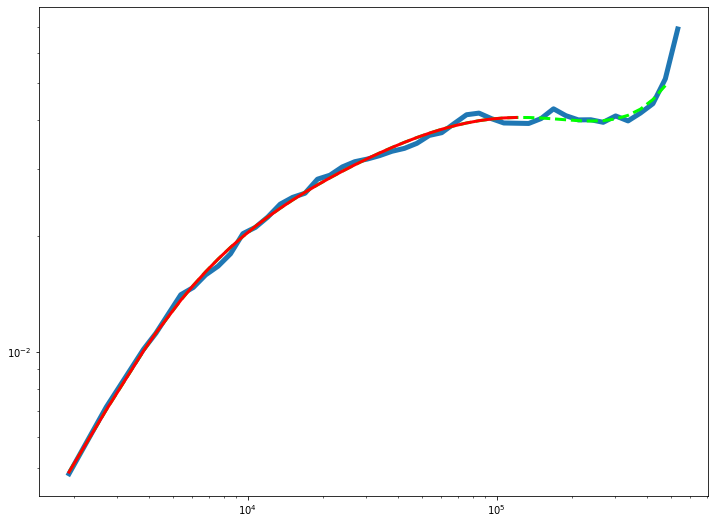

In [322]:
mm = m.copy().iloc[slice(None,-1)]
r_in  = mm.index.copy()
S_in  = mm.values.copy()

r_poly, S_poly = r_in.copy(), np.polyfit(np.log10(r_in.copy()), np.log10(S_in.copy()),6) # better
S_polyvals = 10**np.polyval(S_poly,np.log10(r_poly))


# mm = mm.reindex(mm.index/10000)
# mm = pd.Series([np.nan], index=[1e-16]).append(mm)
# mm[:] = (mm.index)/((mm.index)**2 + 1)
mm[:] = S_polyvals
# mm.plot()
fig = plt.figure(figsize=(12,9))
m.plot(linewidth=5,logx=True,logy=True), mm.plot(linewidth=3,color='lime',linestyle='--')
plt.plot(*(_polyval_smoother(r_in.copy(),S_in.copy(),order=6,truncate='firstlocalmax')),color='red',linewidth=3)
                                     

In [309]:
def _polyval_smoother(r,S,order=8,truncate=None):
    r_poly, S_poly = r.copy(), np.polyfit(np.log10(r.copy()), np.log10(S.copy()),order) # better
    S_polyvals = 10**np.polyval(S_poly,np.log10(r_poly))
    
    if truncate is not None:
        if truncate == 'firstlocalmax':
            end = argrelextrema(S_polyvals, np.greater)[0]
            if len(end) == 0:
                end = len(S_polyvals-1)
            else:
                end = end[0]
        elif truncate == 'max':
            end = np.argmax(S_polvals)
        else:
            end = truncate
        r_poly, S_polyvals = r_poly[:end+1], S_polyvals[:end+1]

        
    return r_poly, S_polyvals

Pinning SF to E_tot/2 beyond maximum given r


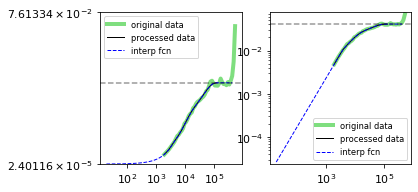

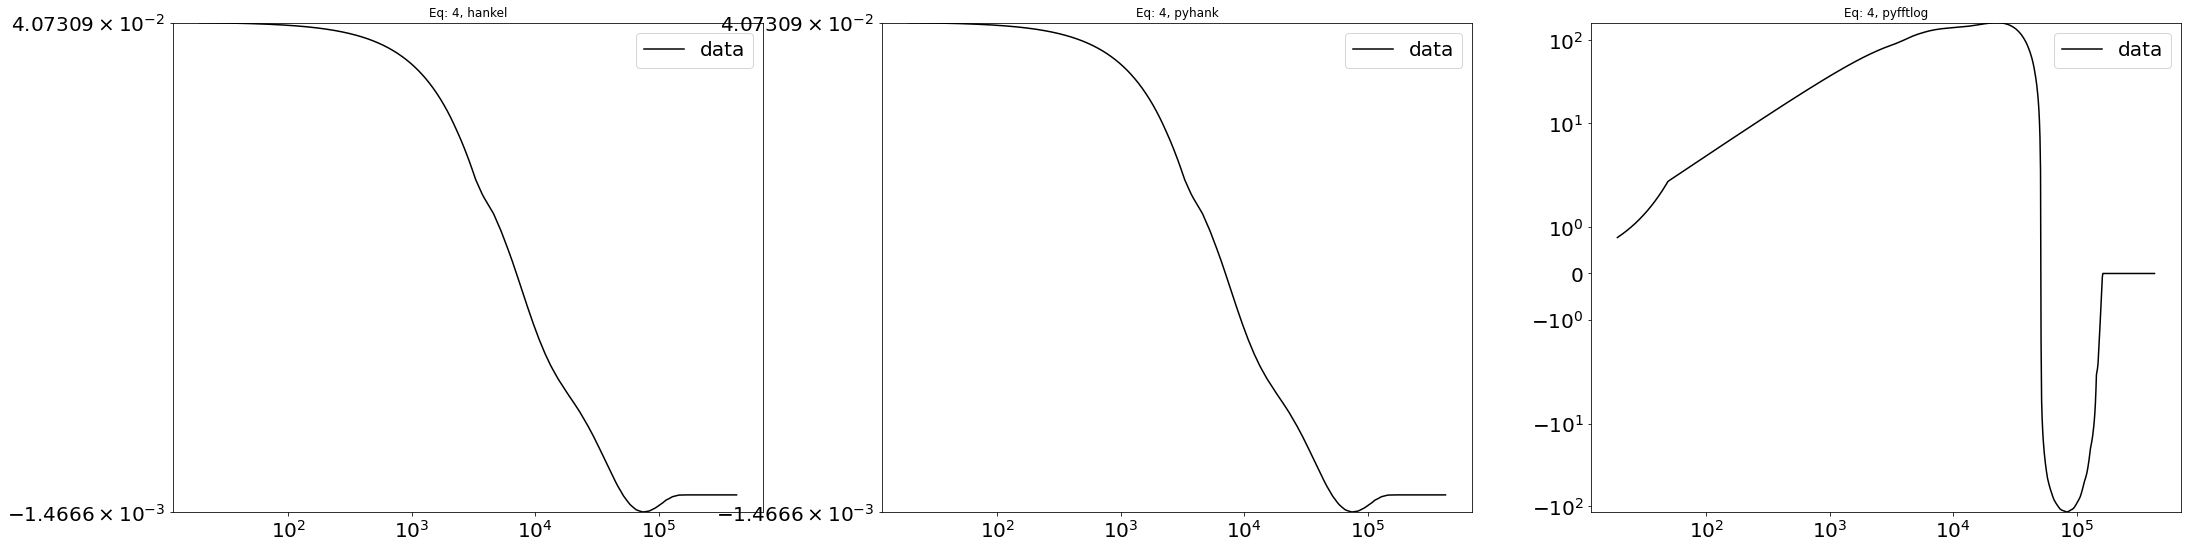

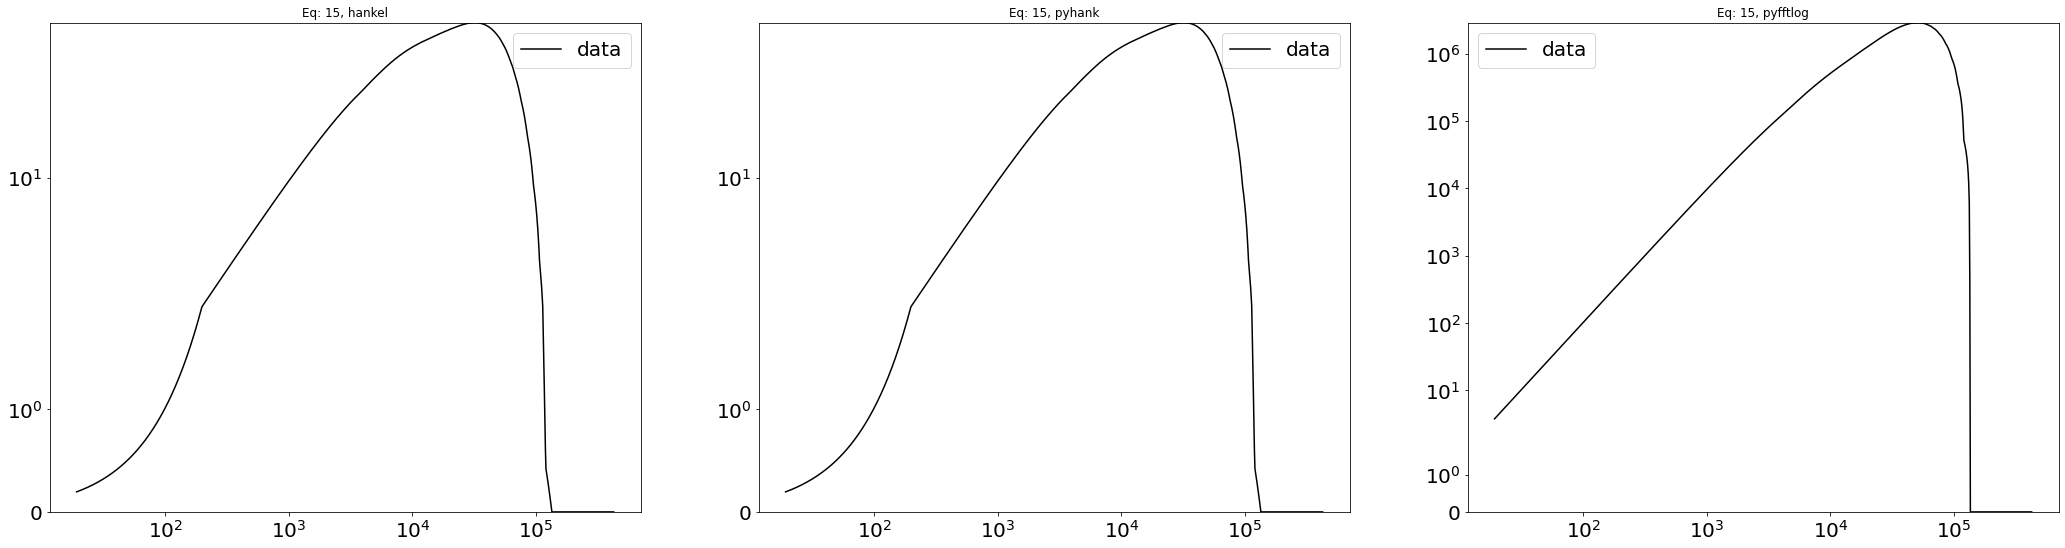

(19.16305633623612, 425201.843119348) (1.282464776355591, 5.628595138388483) (-5.628595138388483, -1.282464776355591)
Calculating Transform with hankel engine, using equation 4
Calculating Transform with pyhank engine, using equation 4
Calculating Transform with pyfftlog engine, using equation 4
 kr changed to  1.0005738350226743
Calculating Transform with hankel engine, using equation 15
Calculating Transform with pyhank engine, using equation 15
Calculating Transform with pyfftlog engine, using equation 15
 kr changed to  0.9993516813167904


In [597]:
scale = 10**0
output = full_process(  m,
                      equations=[4,15],
                      start=None,
                      endd=None,
#                       endd=-16,
#                       endd = argrelextrema(m.values, np.greater)[0][0],# the first local maximum
                      endval='last', # 'last' or 'mean' or 'max'
                      cut_end=True,
                      repeat_end=2,
                      fix_negs_int   = False, # False let's your fcn do things in the interior like go below 0 (is probably more realistic and often can give smoother results)
                      fix_negs_ext   = True, # probably more important to ensure nothing goes awry off the ends esp for pyfftlog, pyhank also appreciates
                      smooth=True,
                      smooth_window=1,
                      smoother = lambda r,s: _polyval_smoother(r.copy(),s.copy(),order=10,truncate='firstlocalmax'),
                      monotonicize=False,
                      f_filter = lambda r,r_in: 1,
#                       f_filter = lambda r: (a1d(r) >= np.min(r_in)), 
#                       f_filter = lambda r,r_in: (a1d(r) >= np.min(r_in)) * (a1d(r) <= np.max(r_in)),

#                       f_filter = lambda r,r_in: np.array([0]) / ((a1d(r) >= np.min(r_in)) * (a1d(r) <= np.max(r_in))) + 1, # 0/True + 1 --> 1, 0/0 + 1 --> np.nan + 1 = np.nan
#                       f_filter = lambda r,r_in: (a1d(r) <  np.max(r_in)),
#                       r_fcn          = lambda r_in:  np.logspace( np.floor(np.log10(r_in[0])- -0), np.ceil(np.log10(r_in[-1])+ -0), int(1e3))
#                       r_fcn          = lambda r_in:  np.linspace( r_in[0]- -0, r_in[-1] -0, int(1e4))
#                       r_fcn          = None,
                      r_fcn          = lambda r_in:  np.geomspace( r_in[0]*10**-2, r_in[-1]*10**0.50, int(1e3)), # add too much on high end and hankel won't like ,not enough and pyfftlog might still ring. Don't add enough on low end and hankel and fft give up early, add too much on low end and little happens but you're making up data
                      setup_structure_func = True,
                      r_scale = 1./scale,
                      S_scale = 1/(scale**2),
                      periodicize = False, # pyhyank seems to prefer no periodicization, can help pyfftlog and hankel but just including max in r_fcn is better
                      periodic_cut_middle=False,
                      dxscale = 6, # a smaller number has a smoothing impact on the derivatives... you could probably also just smooth the data? idk,
                      make_data_plots = True,
                      make_eqns_plots = True,
                      data_plot_scales   = ['symlog','log'],
                      engine_plot_scales = ['symlog','symlog','symlog'],
                      data_fig_scale           = .31,
                      eqns_fig_scale           = 1
                     )

s: 1.8745613327048046e-10
s: 1.4514324268170556e-08
s: 7.150223281854615e-09
s: 1.693944045314174e-13
s: 2.0755033672330635e-08
s: 2.0660414630328125e-08


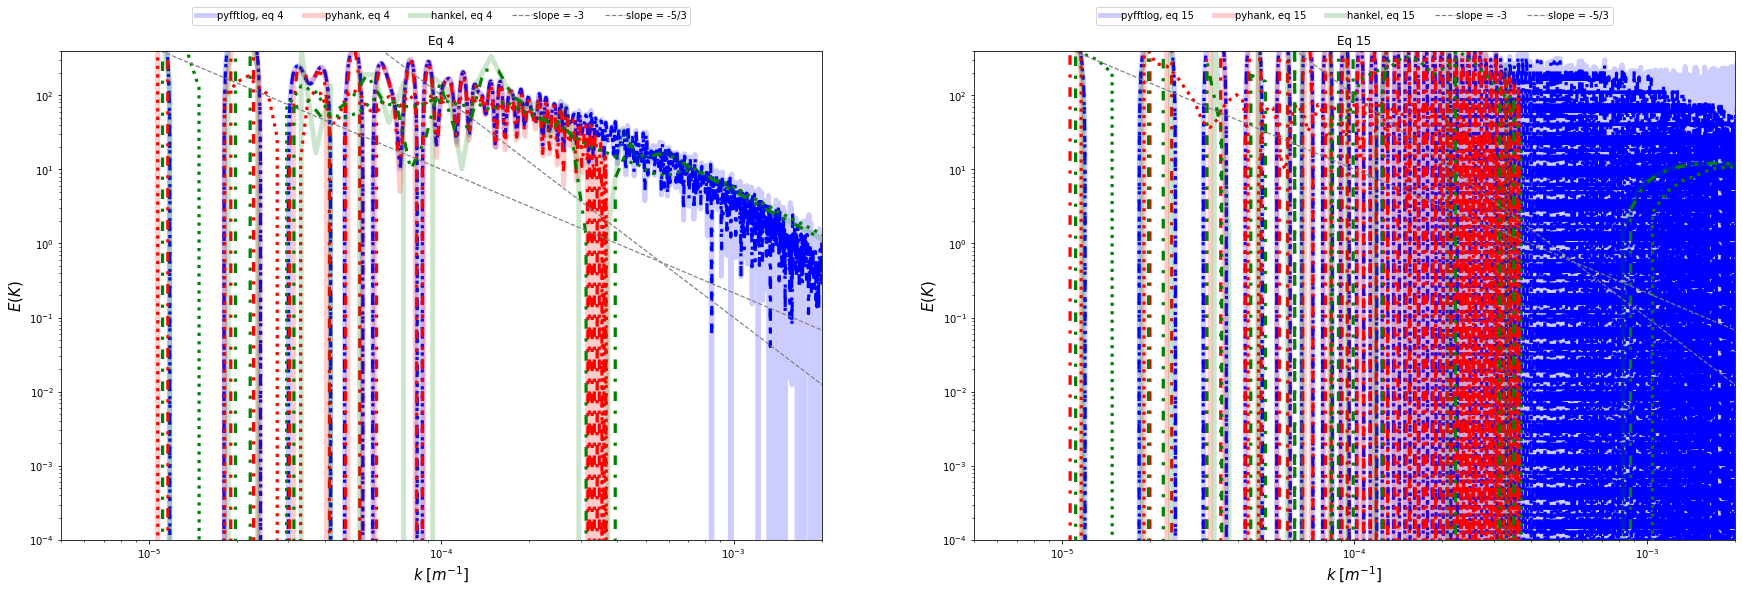

In [526]:
import warnings;
warnings.filterwarnings('ignore');

colors = ['blue','red','green']
smoothing = {'pyhank': lambda x: x, 'hankel': lambda x: np.log10(x), 'pyfftlog': lambda x: np.log10(x)} # smoothing weights determined by whether the input vector is logarithmic or linear 
s = {'pyhank':.001, 'hankel':.00005, 'pyfftlog':.00005}
rolling_periods =  {'pyhank':20, 'hankel':10, 'pyfftlog':5}

output_engines = list(output.keys()); output_engines = [output_engines[2],output_engines[1],output_engines[0]]
output_eqs     = list(output[output_engines[0]]['k'].keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,9),facecolor='white') # prepare our 2x2 grid of subplots in side our figure
axes_list = axes.flatten()  

for i,eq in enumerate(output_eqs):
    _ax = axes_list[i]
    _ax.set_xscale('log'); _ax.set_yscale('log');
    if eq == 4: _ax.set_yscale('log');
    _ax.set_xlabel(r"$k\; [m^{-1}]$", fontsize=15)
    _ax.set_ylabel(r"$E(K)$", fontsize=15);     
    for i, engine in enumerate(output_engines):
        k         = output[engine]['k'][eq]; #k = k/(2*np.pi)
        E         = output[engine]['E'][eq]
#         E_rolling = 10**personal.math.rolling_mean(np.log10(E), axis=0,window=len(k)//25,min_count=1)  # use splines rather than rolling-mean (at least on pyhank) since the resolution may vary wildly (for pyhank we require linear spacing so the small side is undereppresented)
#         E_rolling = 10**(xr.DataArray(np.log10(np.abs(E),coords=[k],dims=['k']).rolling(k=rolling_periods[engine],center=True,min_periods=1).mean())
        E_rolling = personal.math.symlog_rolling_mean(E,window=rolling_periods[engine],center=True, min_periods=rolling_periods[engine])
        E_rolling = np.where(~np.isnan(E_rolling), E_rolling, E) # removes the edge effects values at the beginning w/o shortening array
    
        # mosts problems come from ringing in alternating points, so we can try this...
        E_stack   = np.stack((E[:-1],E[1:]))
        E_alt     = personal.math.geometric_mean(E_stack,axis=0) # works perfectly at beginning, doesn't work at end
        E_alt2    = np.mean(E_stack,axis=0)
        k_alt     = personal.math.geometric_mean(np.stack((k[:-1],k[1:])),axis=0)
        
        E_alt_lin     = np.mean(E_stack,axis=0) # works perfectly at end, poorly at beginning
        replace_inds  = np.any(E_stack<=0,axis=0)
        E_alt[replace_inds] = E_alt_lin[replace_inds]
#         E_alt2[~replace_inds] = E_alt[~replace_inds]

    
        weights = 1/np.diff(smoothing[engine](k)); weights = np.append(weights,weights[-1]); weights = weights**1; weights = weights/np.sum(weights)
        s[engine] =  1/(len(E) * np.nanvar(E))
        print('s: ' + str(s[engine]))
#         E_fit     = np.maximum(scipy.interpolate.UnivariateSpline(k,E, k=5, s=s[engine], w=weights)(k), 0) 
#         E_fit     = scipy.interpolate.UnivariateSpline(np.log10(k),E, k=5, s=s, w=weights)(np.log10(k)) 
        _ax.plot(k, E          , linewidth=5.00, color = colors[i], alpha=0.2, label = engine + ', eq ' + str(eq))
        _ax.plot(k, E_rolling  , linewidth=3.20, color = colors[i], alpha=1.0,label='_nolegend_', linestyle='dotted')
        _ax.plot(k_alt, E_alt  , linewidth=3.20, color = colors[i], alpha=1.0,label='_nolegend_', linestyle=(0,(3,3,1,3))) # loosely dash dotted, see https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html
#         _ax.plot(k_alt, E_alt2 , linewidth=2.20, color = 'k'      , alpha=1.0,label='_nolegend_', linestyle=(0,(3,3,1,3))) # loosely dash dotted, see https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html
        
        
#         _ax.plot(k, k**(0+1) * np.exp(-(k**2)/2), linewidth=4, color = 'purple',alpha=.5)
#         _ax.plot(k, k**(0+1-1) * np.exp(-(k**2)/2), linewidth=4, color = 'orange',alpha=.5)


#         _ax.plot(k, E_fit     , linewidth=2.00, color = colors[i], label='_nolegend_' , linestyle='-.' )
    _ax.axhline(0)
    slope = Fraction(-5,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[1e-4,1e+1]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
    slope = Fraction(-9,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[1e-3,1e-1]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
    
    _ax.set_xlim(np.array([5e-6, 2e-3])*scale);
    _ax.set_ylim(np.array([1e-4, 4e2])*scale);

#     _ax.set_ylim([1e-2, 1e2]);
#     _ax.set_xlim(np.array([1e-1, 1e+1]));
#     _ax.set_ylim(np.array([1e-2, 1e1]));

#     _ax.set_xlim(np.array([1e-3, 1e+3]));
#     _ax.set_ylim(np.array([1e-8, 3e0]));
    
    if eq == 4:
#         _ax.set_xlim(np.array([5e-6, 2e-2])*scale); _ax.set_ylim(np.array([1e-4, 1e2])/scale);
        pass
    else:
#         _ax.set_ylim(np.array([-1e-4, 1e2]));
#         _ax.set_ylim(np.array([1e-8, 1.5e0]));
        pass
        


    _ax.set_title('Eq ' + str(eq))
    _ax.legend(bbox_to_anchor=(.5, 1.10), loc='upper center', ncol=len(_ax.get_legend_handles_labels()[1]), handletextpad=0.1);

season: DJF
Pinning SF to E_tot/2 beyond maximum given r
(18.695928561411193, 366984.83975344925) (1.2717470399145412, 5.564648123795923) (-5.564648123795923, -1.2717470399145412)
Calculating Transform with hankel engine, using equation 4
Calculating Transform with pyhank engine, using equation 4
Calculating Transform with pyfftlog engine, using equation 4
 kr changed to  0.999008928336419
Calculating Transform with hankel engine, using equation 15
Calculating Transform with pyhank engine, using equation 15
Calculating Transform with pyfftlog engine, using equation 15
 kr changed to  1.0002150964731804
season: JFM
Pinning SF to E_tot/2 beyond maximum given r


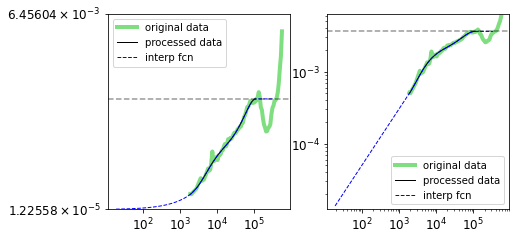

(18.695928561411193, 343707.7908489566) (1.2717470399145412, 5.536189376432726) (-5.536189376432726, -1.2717470399145412)
Calculating Transform with hankel engine, using equation 4
Calculating Transform with pyhank engine, using equation 4
Calculating Transform with pyfftlog engine, using equation 4
 kr changed to  1.001018345561106
Calculating Transform with hankel engine, using equation 15
Calculating Transform with pyhank engine, using equation 15
Calculating Transform with pyfftlog engine, using equation 15
 kr changed to  0.9998186219965811
season: FMA
Pinning SF to E_tot/2 beyond maximum given r
(18.695928561411193, 321907.1544471334) (1.2717470399145412, 5.507730629069529) (-5.507730629069529, -1.2717470399145412)
Calculating Transform with hankel engine, using equation 4
Calculating Transform with pyhank engine, using equation 4
Calculating Transform with pyfftlog engine, using equation 4
 kr changed to  0.9989167042486373
Calculating Transform with hankel engine, using equatio

In [599]:
# m_seas = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'HFRADAR_2KM_KE_rolling_seas_sf.pkl')['structure_fcn']
m_seas = personal.IO.pickle_load(os.path.normpath(os.path.join(file_path, output_savepath)) + '/' + 'HFRADAR_2KM_KE_sf_test_seas.pkl')['structure_fcn']

output_seas = {}
for j,seas in enumerate(seasons):
    print('season: ' + seas)
    output_seas[seas] = output = full_process(
        m_seas[seas],
        equations=[4,15],
        start=None,
#         endd=None,
        endd=-16,
        #                       endd = argrelextrema(m.values, np.greater)[0][0],# the first local maximum
        endval='last', # 'last' or 'mean' or 'max'
        cut_end=True,
        repeat_end=2,
        fix_negs_int   = False, # False let's your fcn do things in the interior like go below 0 (is probably more realistic and often can give smoother results)
        fix_negs_ext   = True, # probably more important to ensure nothing goes awry off the ends esp for pyfftlog, pyhank also appreciates
        smooth=True,
#         smooth_window=1,
        smoother = lambda r,s: _polyval_smoother(r.copy(),s.copy(),order=6,truncate='firstlocalmax'), # something like 6 is pretty stable...
        monotonicize=False,
        f_filter = lambda r,r_in: 1,
        #                       f_filter = lambda r: (a1d(r) >= np.min(r_in)), 
        #                       f_filter = lambda r,r_in: (a1d(r) >= np.min(r_in)) * (a1d(r) <= np.max(r_in)),

        #                       f_filter = lambda r,r_in: np.array([0]) / ((a1d(r) >= np.min(r_in)) * (a1d(r) <= np.max(r_in))) + 1, # 0/True + 1 --> 1, 0/0 + 1 --> np.nan + 1 = np.nan
        #                       f_filter = lambda r,r_in: (a1d(r) <  np.max(r_in)),
        #                       r_fcn          = lambda r_in:  np.logspace( np.floor(np.log10(r_in[0])- -0), np.ceil(np.log10(r_in[-1])+ -0), int(1e3))
        #                       r_fcn          = lambda r_in:  np.linspace( r_in[0]- -0, r_in[-1] -0, int(1e4))
        #                       r_fcn          = None,
        r_fcn          = lambda r_in:  np.geomspace( r_in[0]*10**-2, r_in[-1]*10**0.50, int(1e3)), # add too much on high end and hankel won't like ,not enough and pyfftlog might still ring. Don't add enough on low end and hankel and fft give up early, add too much on low end and little happens but you're making up data
        setup_structure_func = True,
        r_scale = 1./scale,
        S_scale = 1/(scale**2),
        periodicize = False, # pyhyank seems to prefer no periodicization, can help pyfftlog and hankel but just including max in r_fcn is better
        periodic_cut_middle=False,
        dxscale = 6, # a smaller number has a smoothing impact on the derivatives... you could probably also just smooth the data? idk,
#         make_data_plots = True,
        make_data_plots = j==1,
        make_eqns_plots = False,
        data_plot_scales   = ['symlog','log'],
        engine_plot_scales = ['symlog','symlog','symlog'],
        figures_inline     = True,
        data_fig_scale           = .4,
        eqns_fig_scale           = 1
        )

pyfftlog 4 | season:  DJF JFM FMA MAM AMJ MJJ JJA JAS ASO SON OND NDJ 
pyfftlog 15 | season:  DJF JFM FMA MAM AMJ MJJ JJA JAS ASO SON OND NDJ 
pyhank 4 | season:  DJF JFM FMA MAM AMJ MJJ JJA JAS ASO SON OND NDJ 
pyhank 15 | season:  DJF JFM FMA MAM AMJ MJJ JJA JAS ASO SON OND NDJ 
hankel 4 | season:  DJF JFM FMA MAM AMJ MJJ JJA JAS ASO SON OND NDJ 
hankel 15 | season:  DJF JFM FMA MAM AMJ MJJ JJA JAS ASO SON OND NDJ 


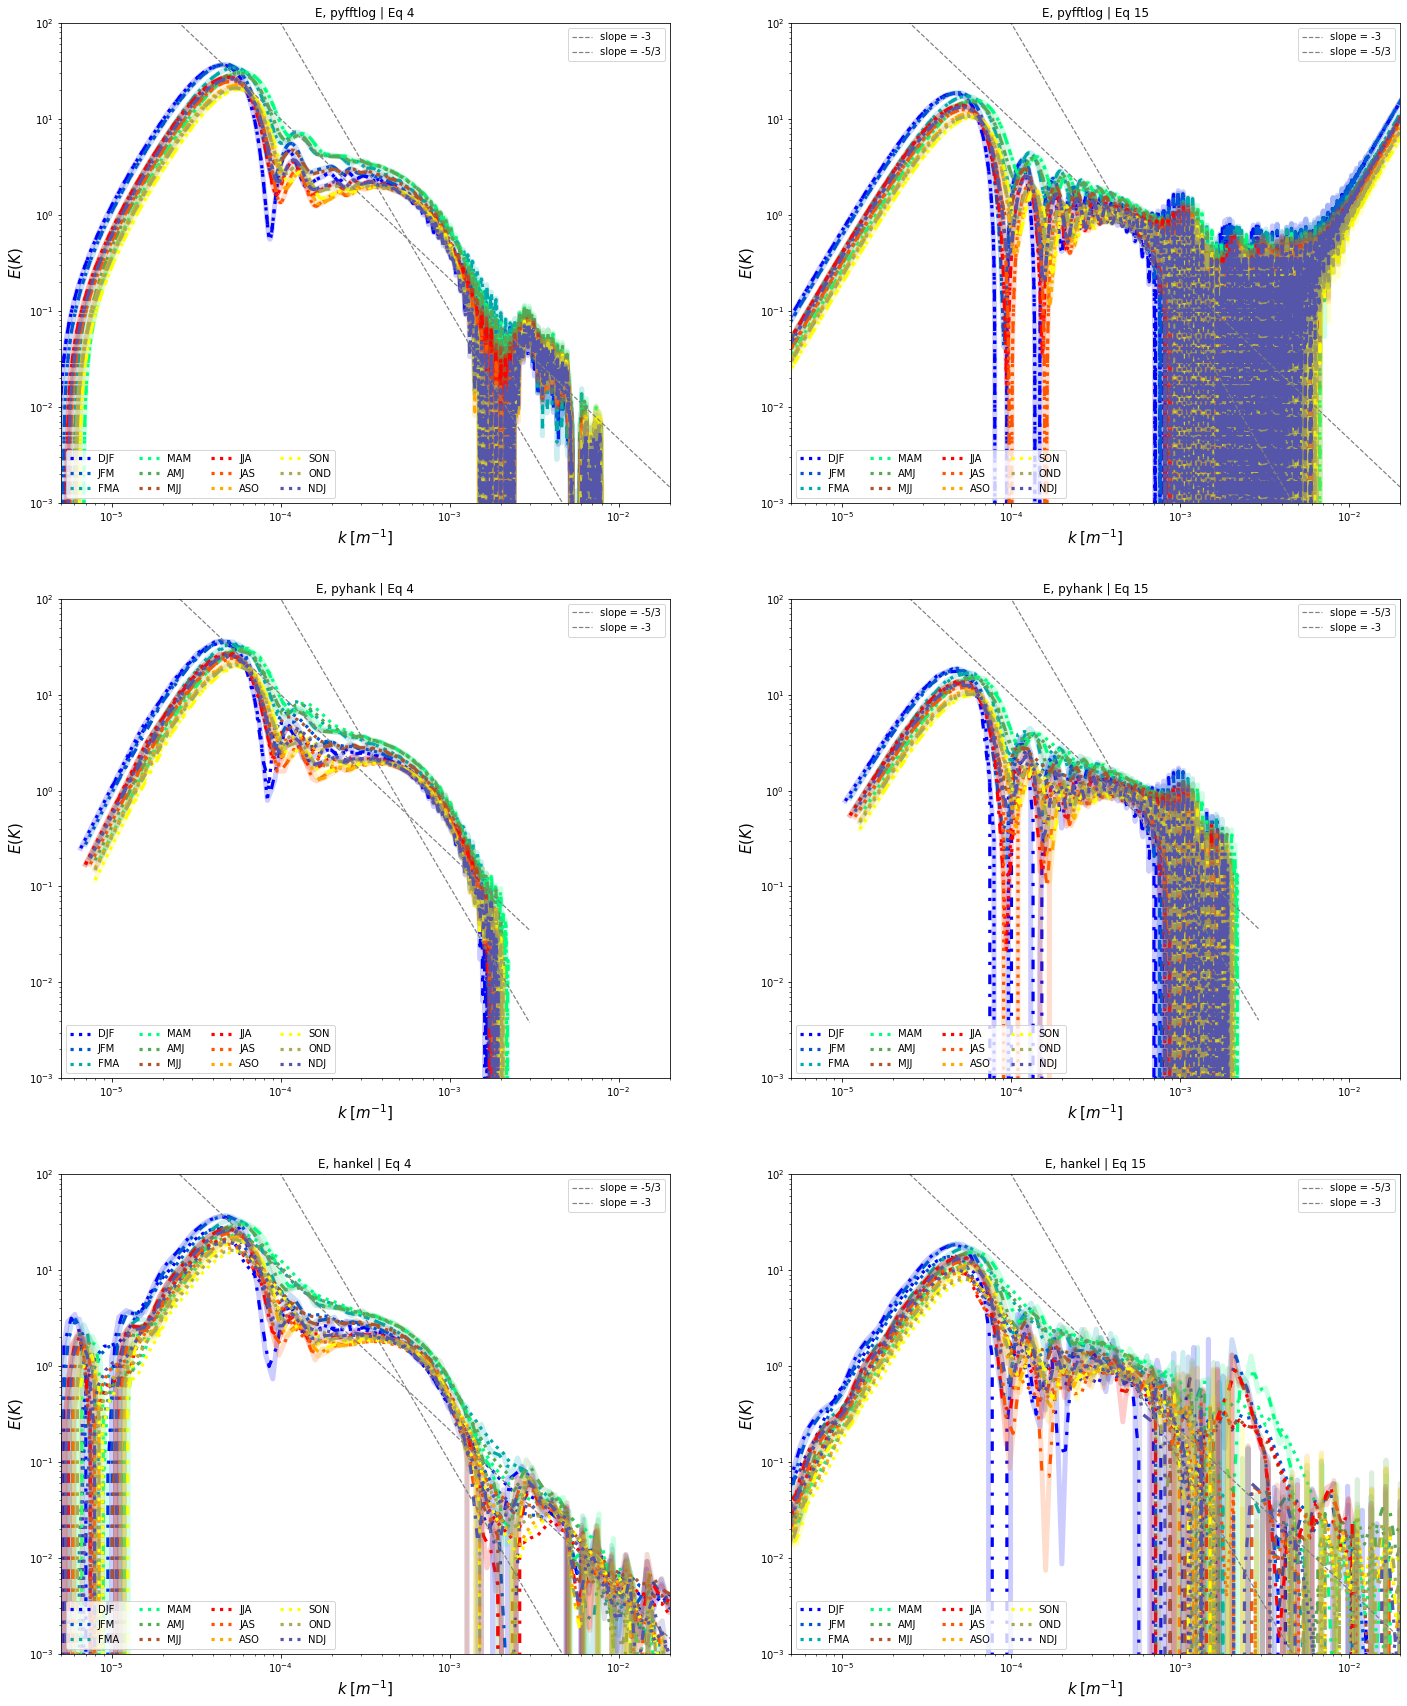

In [600]:
cmap = LinearSegmentedColormap.from_list("mycmap", [[0,0,1],[0,1,.5],[1,0,0],'yellow',[0,0,1]],N=13)
colors = cmap(np.linspace(0, 1, 13)[0:12])
fig = {}; _ax = {}

output_timegroups = list(output_seas.keys())
output_engines = list(output_seas[output_timegroups[0]].keys()); output_engines = [output_engines[2],output_engines[1],output_engines[0]]
output_eqs     = list(output_seas[output_timegroups[0]][output_engines[0]]['k'].keys())

l_eng, l_eqs = len(output_engines), len(output_eqs)
fig, axes = plt.subplots(nrows=l_eng, ncols=l_eqs, figsize=(24,30),facecolor='white') # prepare our 2x2 grid of subplots in side our figure
axes_list = axes.flatten()  

smoothing = {'pyhank': lambda x: x, 'hankel': lambda x: np.log10(x), 'pyfftlog': lambda x: np.log10(x)} # smoothing weights determined by whether the input vector is logarithmic or linear 
s = {'pyhank':.001, 'hankel':.00005, 'pyfftlog':.00005}
rolling_periods =  {'pyhank':20, 'hankel':10, 'pyfftlog':5}

for i,engine in enumerate(output_engines):
    for j,eq in enumerate(output_eqs):
        _ax = axes[i,j]
        _ax.set_xscale('log');  
        _ax.set_yscale('log');
        _ax.set_ylabel(r"$E(K)$", fontsize=15); _ax.set_xlabel(r"$k\; [m^{-1}]$", fontsize=15)
        print(output_engines[i],output_eqs[j],end=' | ')
        print('season: ', end=" ")
        for j,seas in enumerate(seasons):
            
            print(seas,end=" ")
            output = output_seas[seas]
            #             for k, engine in enumerate(['pyhank','pyfftlog','hankel']):
            k         = output[engine]['k'][eq]; # k = k/(2*np.pi)
            E         = output[engine]['E'][eq]
            #         E_rolling = personal.math.rolling_mean(E, axis=0,window=len(k)//20,min_count=1)  # use splines rather than rolling-mean (at least on pyhank) since the resolution may vary wildly (for pyhank we require linear spacing so the small side is undereppresented)   
            E_rolling = personal.math.symlog_rolling_mean(E,window=rolling_periods[engine],center=True, min_periods=rolling_periods[engine])
            E_rolling = np.where(~np.isnan(E_rolling), E_rolling, E) # removes the edge effects values at the beginning w/o shortening array

            # mosts problems come from ringing in alternating points, so we can try this...
            E_stack   = np.stack((E[:-1],E[1:]))
            E_alt     = personal.math.geometric_mean(E_stack,axis=0) # works perfectly at beginning, doesn't work at end
            E_alt2    = np.mean(E_stack,axis=0)
            k_alt     = personal.math.geometric_mean(np.stack((k[:-1],k[1:])),axis=0)

            E_alt_lin     = np.mean(E_stack,axis=0) # works perfectly at end, poorly at beginning
            replace_inds  = np.any(E_stack<=0,axis=0)
            E_alt[replace_inds] = E_alt_lin[replace_inds]
            #         E_alt2[~replace_inds] = E_alt[~replace_inds]

            weights = 1/np.diff(smoothing[engine](k)); weights = np.append(weights,weights[-1]); weights = weights**1; weights = weights/np.sum(weights)
            s[engine] =  1/(len(E) * np.nanvar(E))
            #         print('s: ' + str(s[engine]))
            #         E_fit     = np.maximum(scipy.interpolate.UnivariateSpline(k,E, k=5, s=s[engine], w=weights)(k), 0) 
            #         E_fit     = scipy.interpolate.UnivariateSpline(np.log10(k),E, k=5, s=s, w=weights)(np.log10(k)) 
            _ax.plot(k, E          , linewidth=5.00, color = colors[j], alpha=0.2)
            _ax.plot(k, E_rolling  , linewidth=3.20, color = colors[j], alpha=1.0, label = seas, linestyle='dotted')
            _ax.plot(k_alt, E_alt  , linewidth=3.20, color = colors[j], alpha=1.0, label='_nolegend_', linestyle=(0,(3,3,1,3))) # loosely dash dotted, see https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html
            #         _ax.plot(k_alt, E_alt2 , linewidth=2.20, color = 'k'      , alpha=1.0,label='_nolegend_', linestyle=(0,(3,3,1,3))) # loosely dash dotted, see https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html
            # _ax.plot(k, E_fit     , linewidth=2.20, color = colors[j], label='_nolegend_' )

        print('')
# for engine in output_engines:
        slope = Fraction(-5,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[1e-4,1e+1]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
        slope = Fraction(-9,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[1e-3,1e-1]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
        _ax.set_xlim([5e-6, 2e-2]); _ax.set_ylim([1e-3, 1e2]);
        _ax.set_title('E, ' + engine + ' | Eq ' + str(eq) )
        leg  = _ax.get_legend_handles_labels()
        leg1 = _ax.legend(leg[0][ 0:12], leg[1][ 0:12], loc='lower left',ncol=4);
        _    = _ax.legend(leg[0][12:  ], leg[1][12:  ], loc='upper right' ,ncol=1)
        _    = _ax.add_artist(leg1)
    #     _ax[engine].legend(loc='upper center', ncol=len(_ax[engine].get_legend_handles_labels()[1])/2, handletextpad=0.1);
        _ax.axhline(0)
plt.draw()

In [225]:
# Plot seasonal cycles

In [225]:
personal.IO.pickle_save(fig['hankel'], '../Figures/test_fig_E_hankel.o')

(0.0, 1.0)

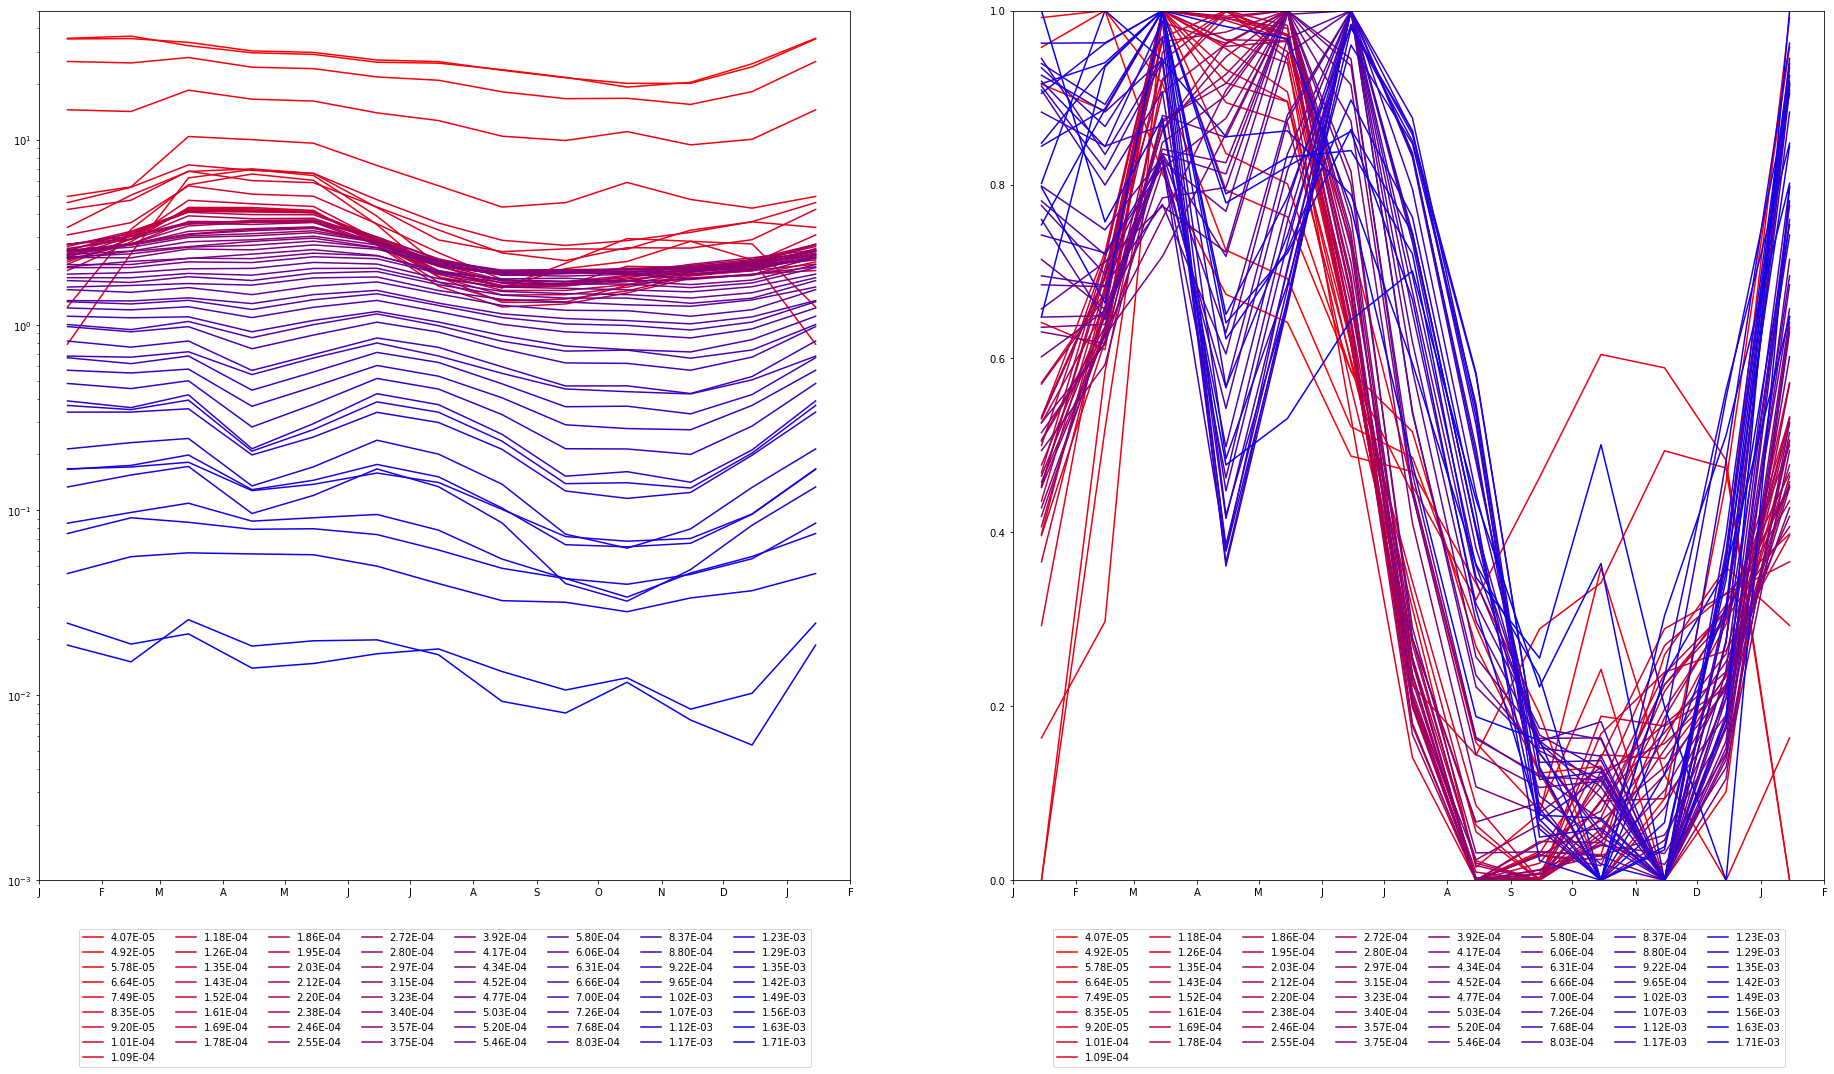

In [617]:
# Plot cycles for various ks
engine = 'pyhank'; eq=4; n = 80

output_timegroups = list(output_seas.keys())
output_engines    = list(output_seas[output_timegroups[0]].keys()); output_engines = [output_engines[2],output_engines[1],output_engines[0]]
output_eqs        = list(output_seas[output_timegroups[0]][output_engines[0]]['k'].keys())

k = output_seas[output_timegroups[0]][engine]['k'][eq]; # k = k/(2*np.pi)
            
peak = 'largest'
if peak == 'earliest': max_ind,max_val = np.inf,-np.inf
if peak == 'largest' : max_ind,max_val = 0     ,-np.inf
for tg in output_timegroups[::+1]:
    _E = output_seas[tg][engine]['E'][eq]
    if peak == 'largest':
        mxind = np.argmax(_E)
        mxval = _E[mxind]
        if mxval  > max_val: max_ind,max_val = mxind,mxval # largest peak
    if peak == 'earliest':
        mxind = argrelextrema(_E, np.greater)[0][0]
        mxval = _E[mxind]
        if mxind < max_ind: max_ind,max_val = mxind,mxval # earliest peak
#     print(max_val,max_ind)
    
ks                   = np.geomspace( k[max_ind], k[-1], n)
xt                   = np.array([np.datetime64(x) for x in dateutil.rrule.rrule(freq=dateutil.rrule.MONTHLY, count=13, dtstart=datetime.datetime(1, 1, 15))])
ks_nearest, ksn_inds = personal.data_structures.nearest(ks, k)
ksn_inds,valid       = np.unique(ksn_inds,return_index=True)
ks_nearest           = ks_nearest[valid]
seas_keys            = list(seasons.keys()); seas_keys.append(seas_keys[0]) # repeat end for plot continuity


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(32,16),facecolor='white') # prepare our 2x2 grid of subplots in side our figure
_ax1,_ax2 = axes

for _ax in axes:
    _ax.set_xlim(xmin=np.datetime64('0001-01-01'),xmax=np.datetime64('0002-02-01'))
    _ax.xaxis.set_major_locator(mdates.MonthLocator())
    _ax.xaxis.set_major_formatter( FuncFormatter(lambda x,pos: mdates.DateFormatter('%b')(x)[0] ))


lc = len(ksn_inds)+1
cmap_here   = LinearSegmentedColormap.from_list("mycmap", [[1,0,0],[0,0,1]],N=lc)
colors_here = cmap_here(np.linspace(0, 1, lc)[0:lc-1])
for i,ind in enumerate(ksn_inds):
    E = np.array([output_seas[seas][engine]['E'][eq][ind] for seas in seas_keys])
    E[E<0] = np.nan
    _ax1.plot(xt,E,color = colors_here[i], label=f"{k[ind]:.2E}" )
    E_norm = sklearn.preprocessing.minmax_scale(np.log10(E),feature_range=(0,1),copy=True)
    _ax2.plot(xt,E_norm,color = colors_here[i], label=f"{k[ind]:.2E}" )

leg1,leg2 = _ax1.legend(loc='upper center',ncol=8, bbox_to_anchor=(.5, -0.05)), _ax2.legend(loc='upper center',ncol=8, bbox_to_anchor=(.5, -0.05))
_ax1.set_yscale('log')   ; _ax1.set_ylim([1e-3, 5.0e1]);
_ax2.set_yscale('linear'); _ax2.set_ylim([0,1])


In [261]:
_=gc.collect()
personal.system.print_memory_item_sizes(local_items=locals().items(),n=-1,size_fcn=sys.getsizeof)

                      rcParams:  9.1 KiB
                          _i21:  8.0 KiB
                           _oh:  4.6 KiB
                           Out:  4.6 KiB
                          _i25:  2.9 KiB
                            _i:  2.8 KiB
                          _iii:  2.8 KiB
                          _i32:  2.8 KiB
                          _i71:  2.8 KiB
                         _i224:  2.8 KiB
                         _i258:  2.8 KiB
                         _i260:  2.8 KiB
                          _i12:  2.7 KiB
                          _i29:  2.7 KiB
                          _i27:  2.7 KiB
                           _i5:  2.6 KiB
                          _i23:  2.6 KiB
                           _i8:  2.6 KiB
                          _i15:  2.6 KiB
                           _i6:  2.6 KiB
                           _i3:  2.6 KiB
                           _ii:  2.5 KiB
                         _i251:  2.5 KiB
                         _i253:  2.5 KiB
                